Notebook utilizzato per la selezione dei parametri da utilizzare nel bdt. Si utilizza una grid search seguita da cross validation

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pickle

## Data preliminary


Setting weigths for background, plotting distributions and correlations of features 

In [2]:
%run analysis_utils.py

In [3]:
df_ML=pd.read_pickle('df_ML.pkl')

In [4]:
bkg=df_ML.query('y==0')
sig=df_ML.query('y==1')

In [5]:
data=pd.concat([bkg,sig],ignore_index=True)
data=data.sample(frac=1)

In [6]:
training_columns=[ 'V0CosPA','ProngsDCA', 'DistOverP', 'ArmenterosAlpha','NpidClustersHe3','V0pt','TPCnSigmaHe3']

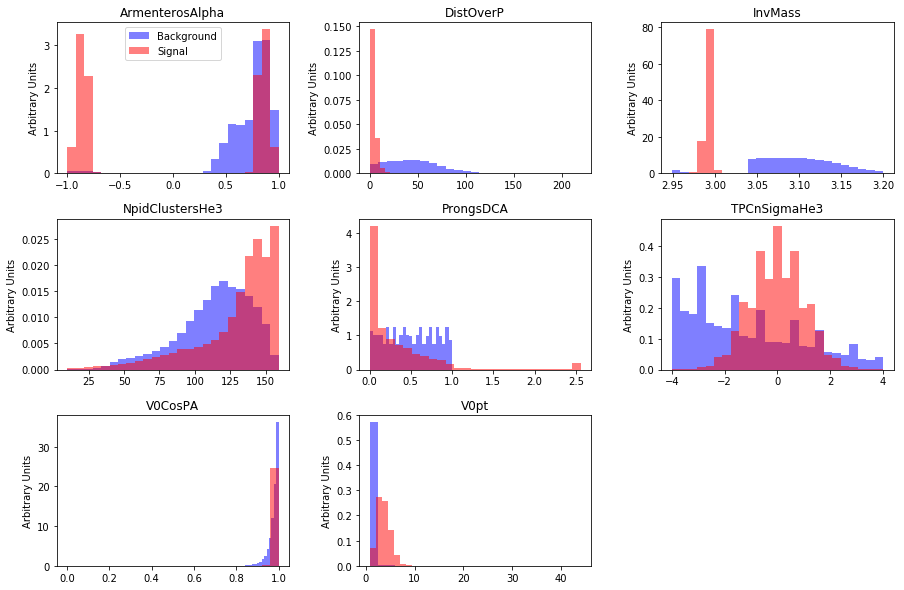

In [7]:
plot_distr(data,training_columns+['InvMass'])

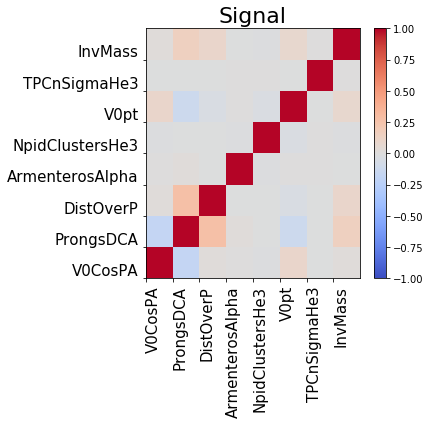

In [8]:
plot_corr(data,training_columns+['InvMass'],"Signal")

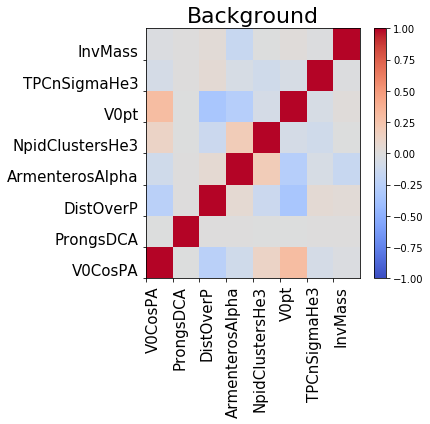

In [9]:
plot_corr(data,training_columns+['InvMass'],"Background")

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
scoring = 'auc'
early_stopping_rounds = 20
num_rounds = 200
params_def = {
    # Parameters that we are going to tune.
    'max_depth':8,
    'eta':0.05,
    'gamma':0.7,
    'min_child_weight':8,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
    'random_state':42,
    'silent':1,
    'nthread':4,
    'tree_method':'hist'}

In [11]:
def optimize_params(dtrain,par):
    %run analysis_utils.py
    gs_dict = {'first_par': {'name': 'max_depth', 'par_values': [i for i in range(2, 10, 2)]},
           'second_par': {'name': 'min_child_weight', 'par_values':[i for i in range(0, 12, 2)]},
          }
    par['max_depth'],par['min_child_weight'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    
    gs_dict = {'first_par': {'name': 'subsample', 'par_values': [i/10. for i in range(4, 10)]},
           'second_par': {'name': 'colsample_bytree', 'par_values': [i/10. for i in range(8, 10)]},
          }
    par['subsample'],par['colsample_bytree'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'gamma', 'par_values': [i/10. for i in range(0, 11)]}} 
    par['gamma'],_ = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'eta', 'par_values': [0.1, 0.05, 0.01, 0.005, 0.001]}}
    par['eta'],n = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    return n

# Train and test vs centrality

### Parameters Optimization

Transforming in xgb Matrix. Optimization with cross validation,tuning of parameters, and final training

In [12]:
centrality_list= [[0,10],[10,30],[30,50]]
model_list=[]
test_list=[]
train_list=[]

In [13]:
for i in range(0,3):
    params=params_def
    cent=centrality_list[i]
    df_cent=data.query('@cent[0]<Centrality<@cent[1]')
    traindata,testdata,ytrain,ytest= train_test_split(df_cent, df_cent['y'], test_size=0.5)
    dtrain = xgb.DMatrix(data=np.asarray(traindata[training_columns]), label=ytrain, feature_names=training_columns)
    #n_round = optimize_params(dtrain,params)
    model_list.append(xgb.train(params, dtrain,num_boost_round=num_rounds))
    test_list.append(testdata)
    train_list.append(traindata)    
    

/home/fmazzasc/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


### Test

Roc curve, feature importance, output of the model and distributions of the features with different cuts on bdt score

ROC_AUC test set: 0.999952
ROC_AUC test set: 0.999922
ROC_AUC test set: 0.999894


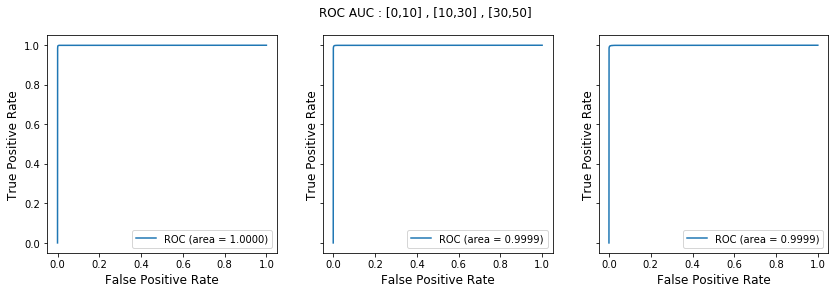

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(14,4), sharey=True)
for i in range(0,3):
    dtest = xgb.DMatrix(data=test_list[i][training_columns])
    y_pred= model_list[i].predict(dtest,output_margin=True)
    ytest=test_list[i]['y']
    print(f"ROC_AUC test set: {roc_auc_score(ytest, y_pred):.6f}")
    fpr, tpr, _ = roc_curve(ytest, y_pred)
    roc_auc = auc(fpr, tpr)
    axs[i].plot(fpr, tpr,label='ROC (area = %0.4f)' % (roc_auc))
    axs[i].legend()   
    axs[i].set_xlabel('False Positive Rate', fontsize=12)
    axs[i].set_ylabel('True Positive Rate', fontsize=12)
    del dtest
fig.suptitle('ROC AUC : [0,10] , [10,30] , [30,50]'); 


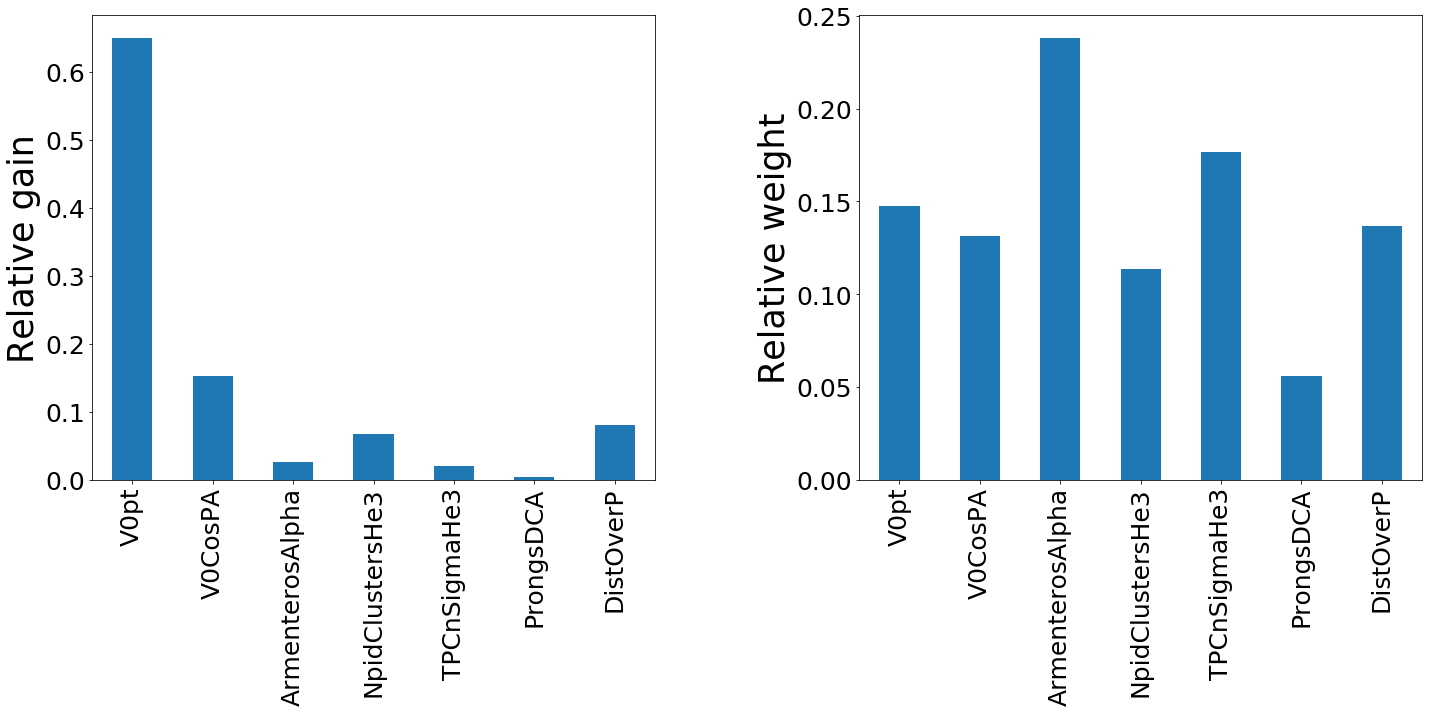

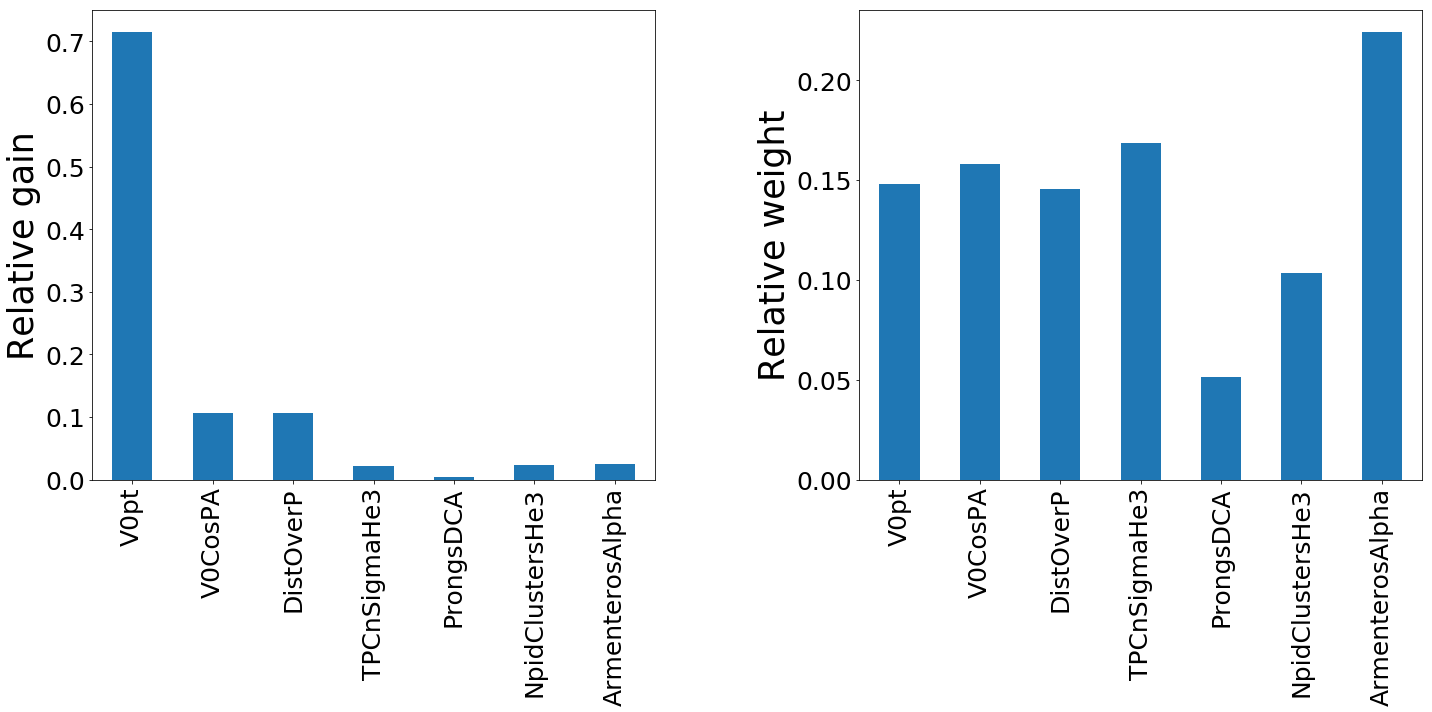

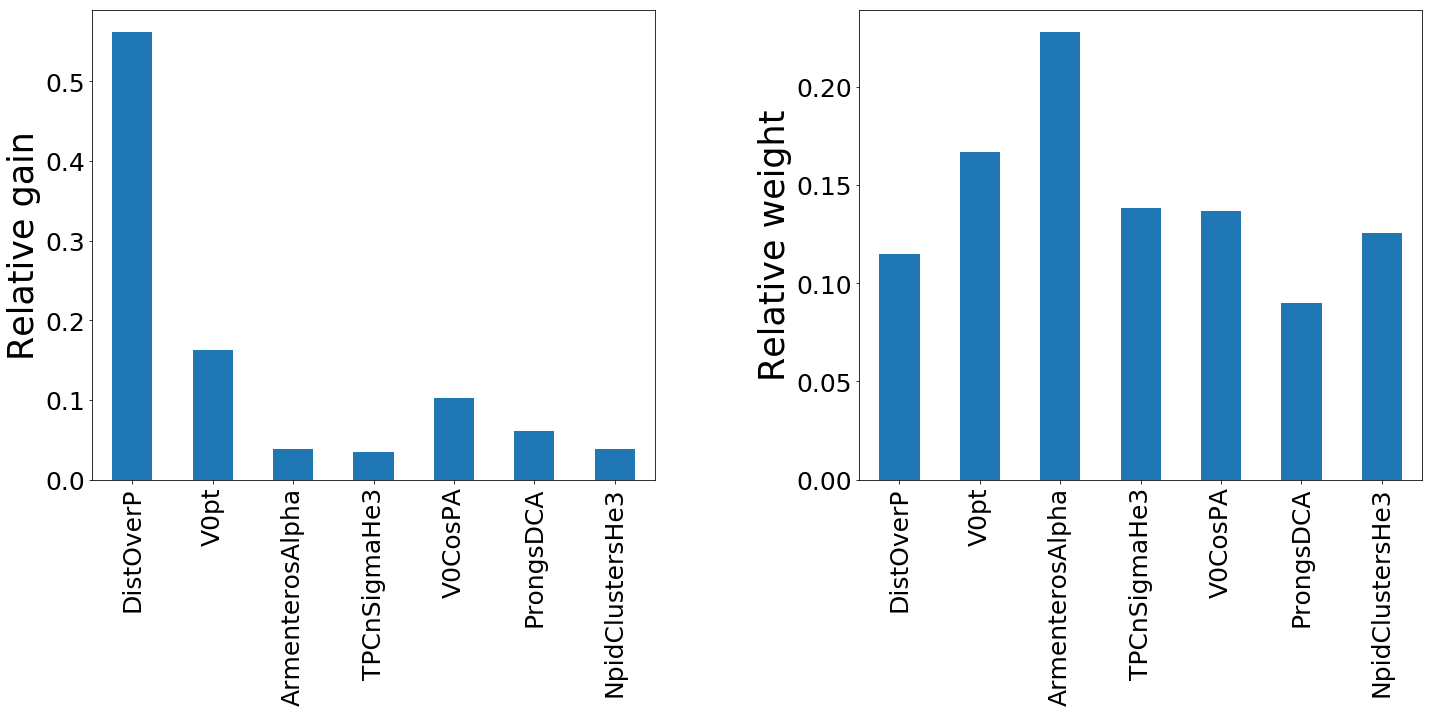

In [15]:
for i in range(0,3):
    plot_feature_imp(model_list[i],['gain','weight'])

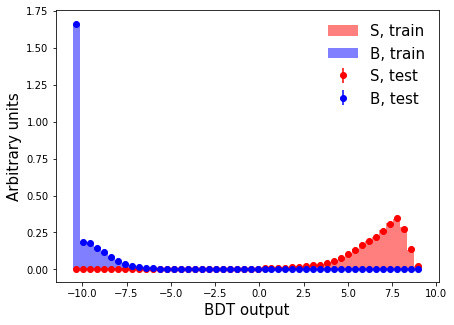

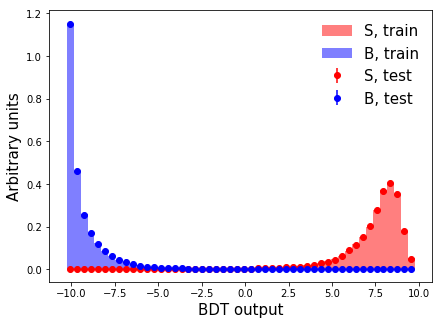

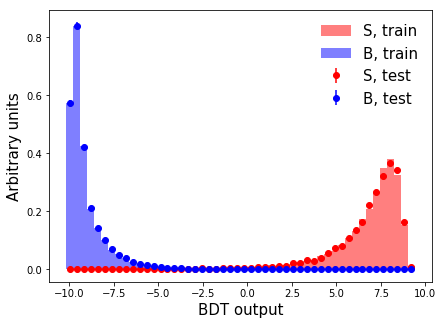

In [16]:
for i in range(0,3):
    plot_output_train_test(model_list[i], train_list[i][training_columns], train_list[i]['y'], test_list[i][training_columns], test_list[i]['y'], branch_names=training_columns,raw=True)

In [18]:
efficiency_cent_array=np.zeros([3,50])

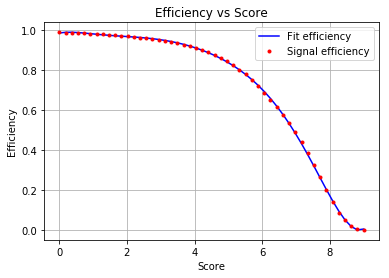

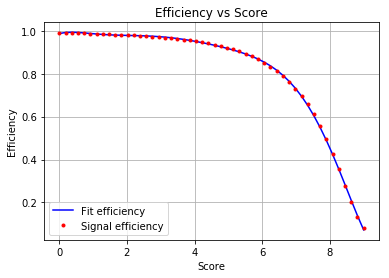

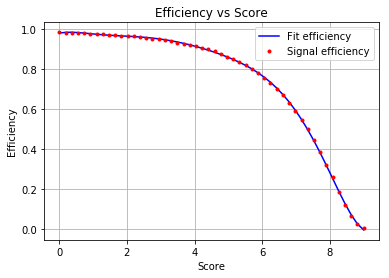

<Figure size 432x288 with 0 Axes>

In [20]:
for i in range(0,3):
    cent=centrality_list[i]
    df=test_list[i]
    dtest = xgb.DMatrix(data=test_list[i][training_columns])
    score=model_list[i].predict(dtest,output_margin=True)
    df.eval('Score = @score',inplace=True)
    efficiency_cent_array[i,:]=EfficiencyVsCuts(df)
    plt.figure()
    del df  
  

In [21]:
np.save("Significance/efficiency_cent_array",efficiency_cent_array)

In [22]:
pickle.dump(model_list[0],open("Significance/model_cent_1.pkl", "wb"))
pickle.dump(model_list[1],open("Significance/model_cent_2.pkl", "wb"))
pickle.dump(model_list[2],open("Significance/model_cent_3.pkl", "wb"))

# Train and test in centrality=[0,40]

In [23]:
params=params_def
df_pt=data.query('Centrality<=40')
traindata,testdata,ytrain,ytest= train_test_split(df_pt, df_pt['y'], test_size=0.5)
dtrain = xgb.DMatrix(data=np.asarray(traindata[training_columns]), label=ytrain, feature_names=training_columns)
#n_round = optimize_params(dtrain,params)
model_cent_integr = xgb.train(params, dtrain,num_boost_round=num_rounds) 
    

/home/fmazzasc/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


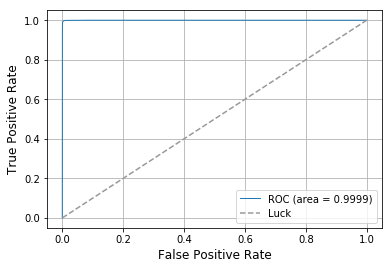

In [24]:
dtest = xgb.DMatrix(data=testdata[training_columns])
y_pred= model_list[i].predict(dtest,output_margin=True)
plot_roc(ytest,y_pred)

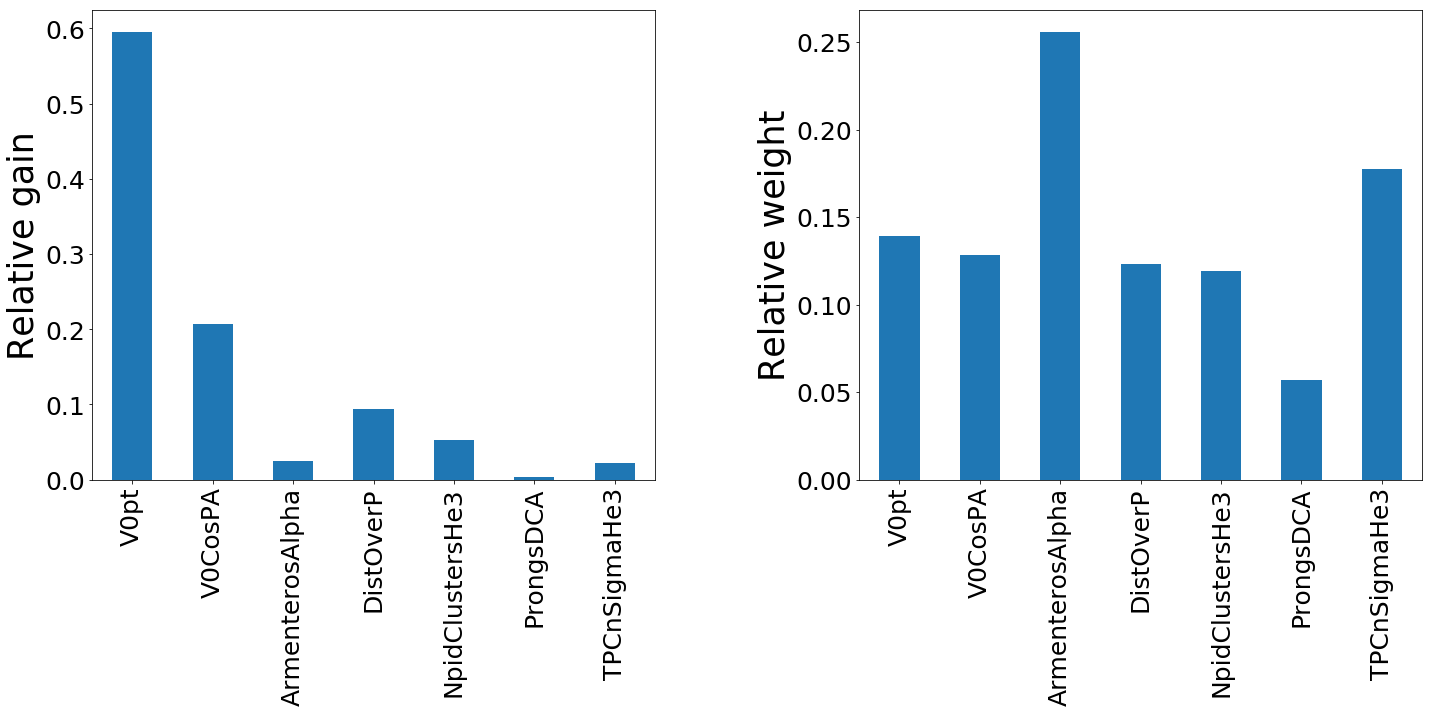

In [25]:
plot_feature_imp(model_cent_integr,['gain','weight'])

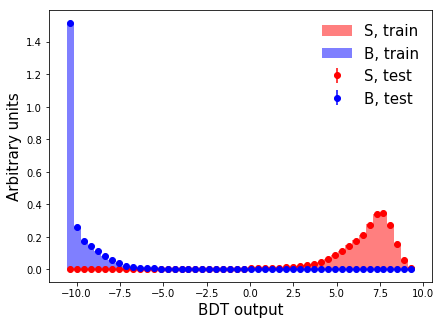

In [26]:
plot_output_train_test(model_cent_integr, traindata[training_columns], ytrain, testdata[training_columns], ytest, branch_names=training_columns,raw=True)

In [27]:
efficiency_0_40_array=np.zeros([1,50])

<Figure size 432x288 with 0 Axes>

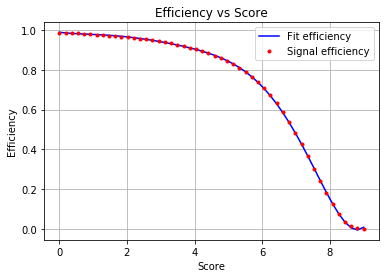

<Figure size 432x288 with 0 Axes>

In [28]:
testdata.eval('Score = @y_pred',inplace=True)
efficiency_0_40_array=EfficiencyVsCuts(testdata)
plt.figure() 
  

In [ ]:
pickle.dump(model_cent_integr,open("Significance/model_cent_integr.pkl", "wb"))

In [ ]:
np.save("Significance/efficiency_0_40_array",efficiency_0_40_array)